In [ ]:
# Data Handling
import os
import json
import random
import pickle
import numpy as np
import pandas as pd
import scipy.io
from scipy.io import mmread
from scipy.stats import spearmanr, pearsonr

# Graph Processing
import networkx as nx
import dgl
import dgl.nn as dglnn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from node2vec import Node2Vec

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import scipy.stats as st

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# Embeddings 
from gensim.models import Word2Vec

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [2]:
datasets = {
    "Bitcoin Alpha": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-alpha.mtx",
    "Bitcoin OTC": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-otc.mtx",
    "Epinions": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx",
    "Slashdot": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-Slashdot081106.mtx"
}


In [3]:
# Load the matrix
epinions_matrix = mmread("soc-sign-epinions.mtx").tocoo()

# Convert to DataFrame
epinions_df = pd.DataFrame({
    'source': epinions_matrix.row,
    'target': epinions_matrix.col,
    'sign': epinions_matrix.data
})
epinions_df.head(10)

,source,target,sign
0,0,1,-1
1,130143,1,1
2,5079,2,1
3,2,3,1
4,116,3,1
5,3579,3,1
6,5079,3,1
7,7263,4,1
8,4,5,-1
9,5,5,1


In [4]:
print(epinions_df.head(10).to_latex(index=False))


\begin{tabular}{rrr}
\toprule
source & target & sign \\
\midrule
0 & 1 & -1 \\
130143 & 1 & 1 \\
5079 & 2 & 1 \\
2 & 3 & 1 \\
116 & 3 & 1 \\
3579 & 3 & 1 \\
5079 & 3 & 1 \\
7263 & 4 & 1 \\
4 & 5 & -1 \\
5 & 5 & 1 \\
\bottomrule
\end{tabular}



In [5]:
graphs = {}

for name, path in datasets.items():
    print(f" Loading dataset: {name} ...")
    mtx_data = scipy.io.mmread(path)
    G = nx.from_scipy_sparse_array(mtx_data, create_using=nx.Graph)
    graphs[name] = G
    print(f"{name} - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}\n")

 Loading dataset: Bitcoin Alpha ...
Bitcoin Alpha - Nodes: 3783, Edges: 14124

 Loading dataset: Bitcoin OTC ...
Bitcoin OTC - Nodes: 5881, Edges: 21492

 Loading dataset: Epinions ...
Epinions - Nodes: 131828, Edges: 711783

 Loading dataset: Slashdot ...
Slashdot - Nodes: 77357, Edges: 468554



In [6]:
degree_distributions = {}

for name, G in graphs.items():
    
    degree_dict = dict(G.degree())
    degree_series = pd.Series(degree_dict)

    # Save degree distribution
    degree_df = pd.DataFrame({"Node": list(G.nodes), "Degree": degree_series})
    degree_df.to_csv(f"{name}_degree_distribution.csv", index=False)

    degree_distributions[name] = degree_series.describe()

# Convert results to DataFrame
degree_summary_df = pd.DataFrame(degree_distributions)
print("\n Summary of Degree Distributions:")
print(degree_summary_df)


 Summary of Degree Distributions:
       Bitcoin Alpha  Bitcoin OTC       Epinions      Slashdot
count    3783.000000  5881.000000  131828.000000  77357.000000
mean        7.467090     7.308961      10.798662     12.114069
std        20.055671    23.039354      51.573440     40.393764
min         1.000000     1.000000       1.000000      0.000000
25%         1.000000     1.000000       1.000000      1.000000
50%         2.000000     2.000000       1.000000      2.000000
75%         6.000000     5.000000       4.000000      8.000000
max       511.000000   795.000000    3558.000000   2537.000000


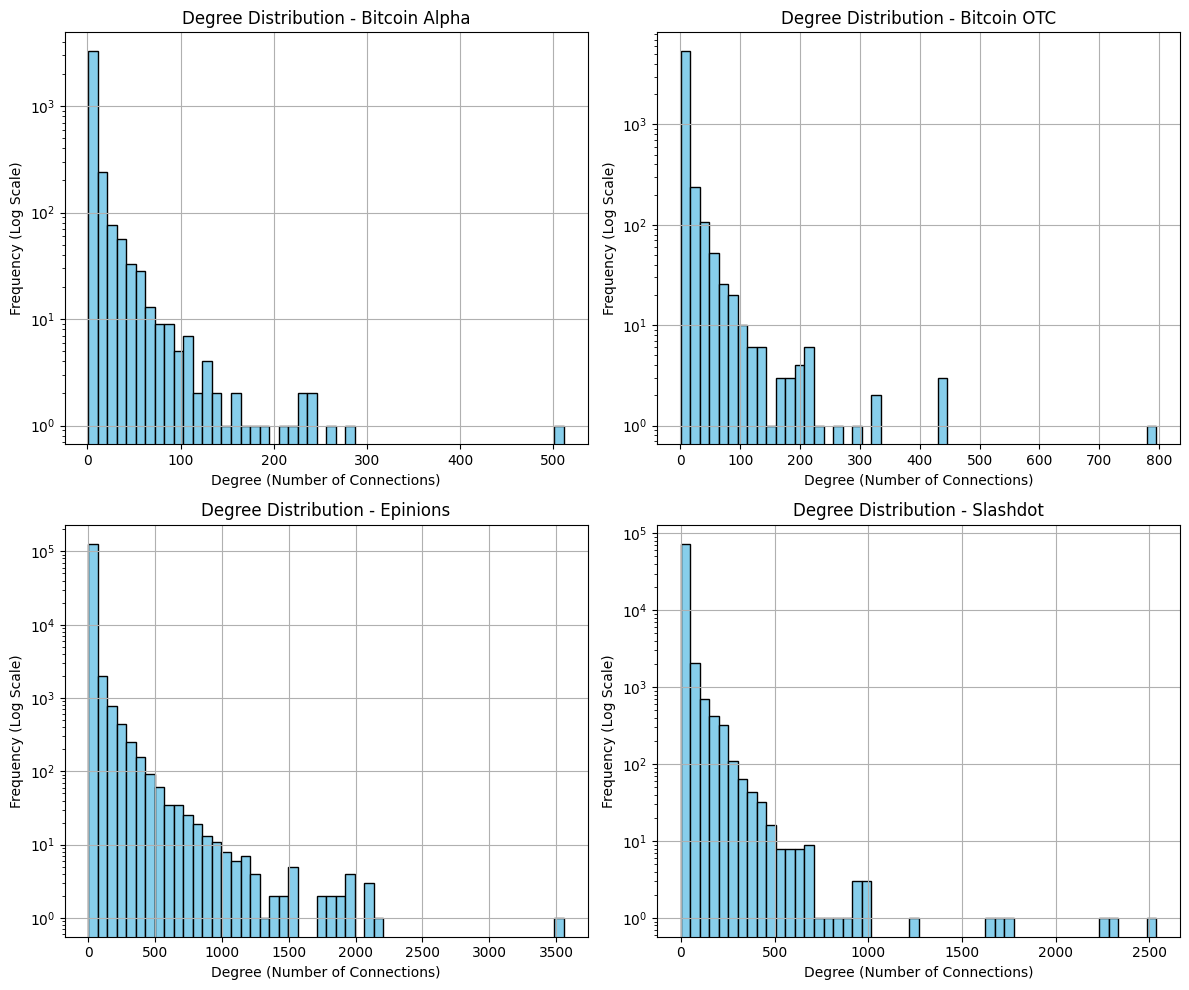

In [7]:
# Plot degree distributions for all datasets
plt.figure(figsize=(12, 10))

for i, (name, G) in enumerate(graphs.items(), 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    degree_sequence = [deg for _, deg in G.degree()]
    plt.hist(degree_sequence, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel("Degree (Number of Connections)")
    plt.ylabel("Frequency (Log Scale)")
    plt.title(f"Degree Distribution - {name}")
    plt.grid(True)

plt.tight_layout()
plt.savefig("degree_distributions_all.pdf", dpi=300)
plt.show()


- Most nodes in all four networks have a low degree — this means that the majority of users are only sparsely connected (degree ≤ 10).
- The degree distributions are right-skewed, suggesting that only a few nodes act as highly connected hubs.
- This pattern is especially evident in **Epinions** and **Slashdot**, where some nodes have degrees in the thousands.
- Using a logarithmic scale for frequency improves the visualization of this skewed distribution and highlights the power-law-like behavior, which is common in social networks.

In [8]:
# Compute graph density for each dataset
for name, G in graphs.items():
    graph_density = nx.density(G)
    print(f"{name} - Number of Nodes: {G.number_of_nodes()}")
    print(f"{name} - Number of Edges: {G.number_of_edges()}")
    print(f"{name} - Graph Density: {graph_density:.4f}\n")



Bitcoin Alpha - Number of Nodes: 3783
Bitcoin Alpha - Number of Edges: 14124
Bitcoin Alpha - Graph Density: 0.0020

Bitcoin OTC - Number of Nodes: 5881
Bitcoin OTC - Number of Edges: 21492
Bitcoin OTC - Graph Density: 0.0012

Epinions - Number of Nodes: 131828
Epinions - Number of Edges: 711783
Epinions - Graph Density: 0.0001

Slashdot - Number of Nodes: 77357
Slashdot - Number of Edges: 468554
Slashdot - Graph Density: 0.0002



Graph density is a measure of how many connections exist in a network relative to the total possible connections. It is calculated as:

- **Bitcoin Alpha**: Density = 0.0020
- **Bitcoin OTC**: Density = 0.0012
- **Epinions**: Density = 0.0001
- **Slashdot**: Density = 0.0002

Interpretation:
- All networks are **very sparse**, meaning most nodes are not directly connected.
- **Epinions** and **Slashdot** are particularly sparse due to their very large number of nodes.
- This kind of sparsity is common in real-world social networks, where only a fraction of all possible connections are realized.



Potential features:

In [45]:
# List of potential feature files 
feature_files = {
    "Bitcoin Alpha Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-alpha_nodeid.mtx",
    "Bitcoin OTC Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-otc_nodeid.mtx"
}

In [46]:
# Try loading feature files
for name, path in feature_files.items():
    try:
        print(f"\nChecking features in: {name}")
        feature_data = scipy.io.mmread(path)
        
        # Convert to array and check shape
        feature_array = feature_data.toarray() if hasattr(feature_data, "toarray") else feature_data
        print(f"{name} - Shape: {feature_array.shape}")

        # Print first 5 node features 
        if len(feature_array) > 0:
            print(f"First 5 Nodes' Features: {feature_array[:5]}")

    except Exception as e:
        print(f"Error loading {name}: {e}")


Checking features in: Bitcoin Alpha Node IDs
Error loading Bitcoin Alpha Node IDs: Line 1: Not a Matrix Market file. Missing banner.

Checking features in: Bitcoin OTC Node IDs
Error loading Bitcoin OTC Node IDs: Line 1: Not a Matrix Market file. Missing banner.


the values indicate just a numerical index for nodes, not meaningful attributes.

Bitcoin Alpha - High-Degree Nodes: 402
Bitcoin Alpha - Low-Degree Nodes: 1368

Bitcoin OTC - High-Degree Nodes: 597
Bitcoin OTC - Low-Degree Nodes: 2260

Epinions - High-Degree Nodes: 13193
Epinions - Low-Degree Nodes: 67325

Slashdot - High-Degree Nodes: 7821
Slashdot - Low-Degree Nodes: 28191



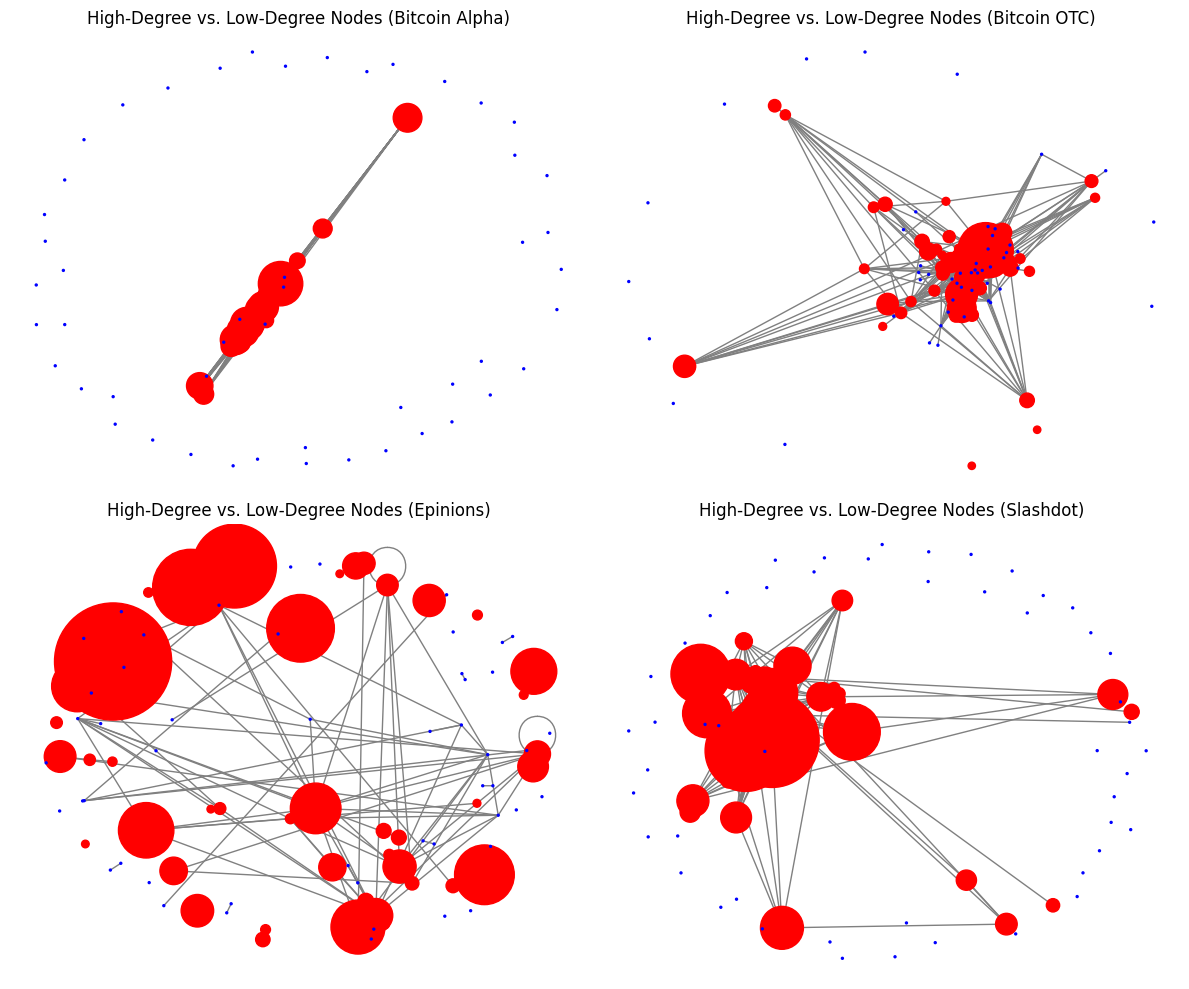

In [47]:
# Identify high-degree and low-degree nodes for each dataset
high_degree_nodes = {}
low_degree_nodes = {}

for name, G in graphs.items():
    degree_series = pd.Series(dict(G.degree()))

    # Define top 10% and bottom 10% threshold
    high_degree_threshold = degree_series.quantile(0.90)
    low_degree_threshold = degree_series.quantile(0.10)

    # Select nodes
    high_degree_nodes[name] = degree_series[degree_series >= high_degree_threshold].index
    low_degree_nodes[name] = degree_series[degree_series <= low_degree_threshold].index

    print(f"{name} - High-Degree Nodes: {len(high_degree_nodes[name])}")
    print(f"{name} - Low-Degree Nodes: {len(low_degree_nodes[name])}\n")

# Create a 2x2 plot for visualizing all datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, G) in enumerate(graphs.items()):
    # Sample 50 high-degree and 50 low-degree nodes
    subgraph_nodes = list(high_degree_nodes[name][:50]) + list(low_degree_nodes[name][:50])
    subG = G.subgraph(subgraph_nodes)

    # Define node colors: red for high-degree, blue for low-degree
    color_map = ['red' if node in high_degree_nodes[name] else 'blue' for node in subgraph_nodes]

    # Define node sizes based on degree
    node_sizes = [G.degree(n) * 2 for n in subgraph_nodes]

    # Plot the subgraph
    plt.sca(axes[i])
    nx.draw(subG, node_color=color_map, node_size=node_sizes, edge_color="gray")
    plt.title(f"High-Degree vs. Low-Degree Nodes ({name})")

plt.tight_layout()
plt.show()


- **Red nodes** represent **high-degree** nodes (top 10% by connectivity).
- **Blue nodes** represent **low-degree** nodes (bottom 10% by connectivity).
- **Node size is proportional to its degree** — more connected nodes appear larger.

#### Key Observations:

- **Bitcoin Alpha**:  
  High-degree nodes (red) are centrally clustered, often connecting to each other. Low-degree nodes (blue) are more peripheral and mostly disconnected, forming a hub-and-spoke pattern.

- **Bitcoin OTC**:  
  Displays a dense core of high-degree nodes, with low-degree nodes still somewhat connected to this core. A more cohesive structure compared to Bitcoin Alpha.

- **Epinions**:  
  Shows rich interconnectivity across both high- and low-degree nodes. The subgraph is dense, indicating a more egalitarian interaction pattern where even low-degree nodes are somewhat connected.

- **Slashdot**:  
  High-degree nodes form a dense and centralized cluster. Low-degree nodes are loosely attached, many appearing isolated. The contrast in connectivity is visually stark.

These patterns reveal important network dynamics, such as whether influence is concentrated in a few "hub" nodes or more evenly distributed. High-degree nodes tend to serve as connectors, and their spatial clustering shows how centralized each network is.


# Full graph experiments

Nodes: 131828, Edges: 841372, Density: 0.000048
Average Clustering Coefficient: 0.127945
Degree Statistics: {'Mean Degree': 12.764693388354523, 'Std Degree': 60.54927167495869, 'Min Degree': 1, 'Max Degree': 3622}
Average Shortest Path Length (SCC): 4.215139
Strongly Connected Components: 88609
Weakly Connected Components: 5816
Spearman correlation (degree vs clustering): SignificanceResult(statistic=0.7246791552521861, pvalue=0.0)
Pearson correlation (degree vs clustering): PearsonRResult(statistic=0.020713758477751563, pvalue=5.414591254257019e-14)


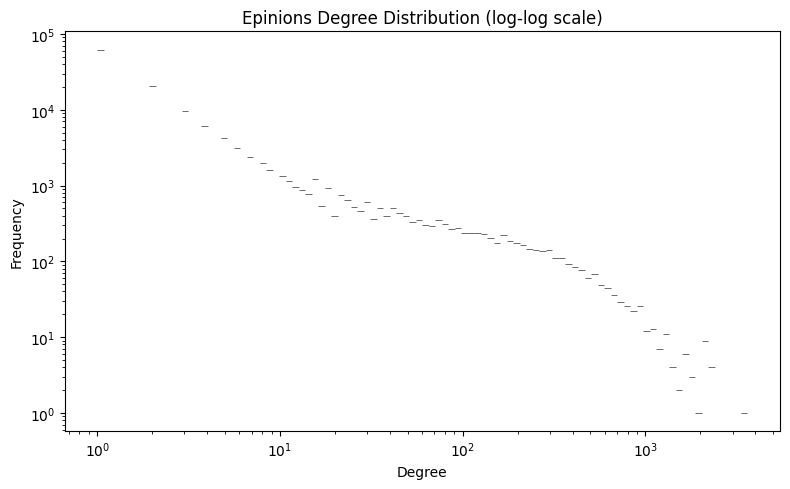

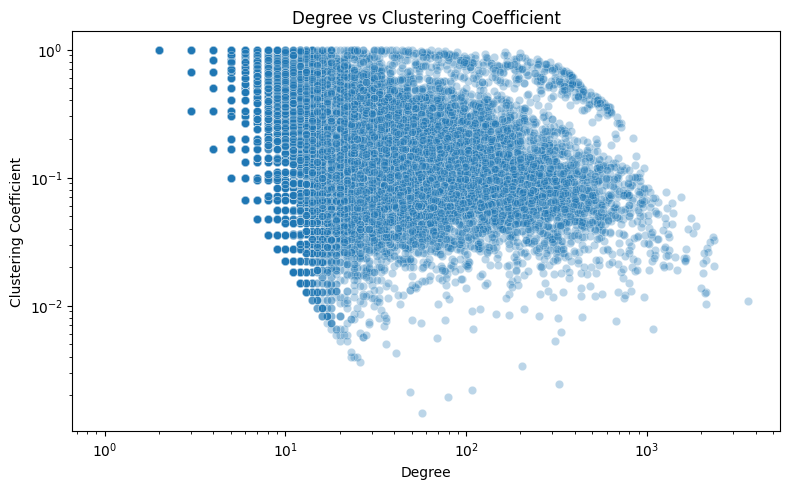

In [ ]:
# Load and parse matrix
matrix = mmread("soc-sign-epinions.mtx").tocoo()
epinions_df = pd.DataFrame({
    'source': matrix.row,
    'target': matrix.col,
    'sign': matrix.data
})

# Build directed graph with signed edges
G = nx.DiGraph()
for row in epinions_df.itertuples(index=False):
    G.add_edge(row.source, row.target, sign=row.sign)

# 1. Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
print(f'Nodes: {num_nodes}, Edges: {num_edges}, Density: {density:.6f}')

# 2. Clustering coefficient (requires undirected)
G_undirected = G.to_undirected()
avg_clustering = nx.average_clustering(G_undirected)
print(f'Average Clustering Coefficient: {avg_clustering:.6f}')

# 3. Degree statistics
degrees = [deg for _, deg in G.degree()]
degree_stats = {
    "Mean Degree": np.mean(degrees),
    "Std Degree": np.std(degrees),
    "Min Degree": np.min(degrees),
    "Max Degree": np.max(degrees),
}
print("Degree Statistics:", degree_stats)

# 4. Shortest path (largest SCC)
if nx.is_strongly_connected(G):
    avg_path_len = nx.average_shortest_path_length(G)
else:
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G_scc = G.subgraph(largest_scc)
    avg_path_len = nx.average_shortest_path_length(G_scc)
print(f'Average Shortest Path Length (SCC): {avg_path_len:.6f}')

# 5. Connected components
print(f'Strongly Connected Components: {nx.number_strongly_connected_components(G)}')
print(f'Weakly Connected Components: {nx.number_weakly_connected_components(G)}')

# 6. Correlation: Degree vs Clustering
clustering_dict = nx.clustering(G_undirected)
clustering_values = [clustering_dict[n] for n in G.nodes()]
degree_values = [G.degree(n) for n in G.nodes()]
df_corr = pd.DataFrame({'degree': degree_values, 'clustering': clustering_values})

spearman_corr = spearmanr(df_corr['degree'], df_corr['clustering'])
pearson_corr = pearsonr(df_corr['degree'], df_corr['clustering'])

print(f"Spearman correlation (degree vs clustering): {spearman_corr}")
print(f"Pearson correlation (degree vs clustering): {pearson_corr}")

# 7. Degree distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=100, log_scale=(True, True))
plt.title('Epinions Degree Distribution (log-log scale)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 8. Degree vs Clustering scatter
plt.figure(figsize=(8, 5))
sns.scatterplot(x='degree', y='clustering', data=df_corr, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree vs Clustering Coefficient')
plt.xlabel('Degree')
plt.ylabel('Clustering Coefficient')
plt.tight_layout()
plt.show()


# Baseline

In [56]:
# GAE Model
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        return self.conv2(graph, h)

class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edges):
        src, dst = edges[:, 0], edges[:, 1]
        h = torch.cat([z[src], z[dst]], dim=1)
        h = F.elu(self.fc1(h))
        return torch.sigmoid(self.fc2(h)).squeeze()

class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super().__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)

    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

# One run
def epinions_baseline():
    mtx = scipy.io.mmread("/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx").tocoo()
    src = torch.tensor(mtx.row, dtype=torch.long)
    dst = torch.tensor(mtx.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx.data, dtype=torch.float)

    graph = dgl.graph((src, dst), num_nodes=max(src.max(), dst.max()).item() + 1)
    graph.edata['sign'] = edge_signs
    graph = dgl.add_self_loop(graph)

    # Compute signed node features
    num_nodes = graph.num_nodes()
    pos_deg = torch.zeros(num_nodes)
    neg_deg = torch.zeros(num_nodes)
    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    # Sample random negative edges (not hard negatives)
    def sample_random_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            edges = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(edges.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    pos_edges = torch.stack((src, dst), dim=1)
    neg_edges = sample_random_negative_edges(graph, len(pos_edges))

    # Split
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train], dim=0)
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test], dim=0)
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Train model
    model = GAE(2, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_preds = model(graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness
    degs = graph.in_degrees().numpy()
    node_degrees = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    bins = np.percentile(node_degrees, [0, 50, 100])
    bin_ids = np.digitize(node_degrees, bins[1:-1])

    degree_auc = []
    dp_vals = []
    eo_vals = []
    for i in range(2):
        idx = np.where(bin_ids == i)[0]
        if len(idx) == 0:
            continue
        degree_auc.append(roc_auc_score(test_labels[idx], test_preds[idx]))
        dp_vals.append(np.mean(pred_labels[idx]))
        y_true, y_pred = test_labels[idx], pred_labels[idx]
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            eo_vals.append(tp / (tp + fn + 1e-8))
        else:
            eo_vals.append(0)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": max(degree_auc) - min(degree_auc),
        "DP Gap": max(dp_vals) - min(dp_vals),
        "EO Gap": max(eo_vals) - min(eo_vals)
    }

# 10 runs
results = [epinions_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.929236  0.871377   0.883036  0.858413  0.869858    0.185990  0.609216   
std   0.006451  0.013199   0.033749  0.021031  0.010553    0.066662  0.032122   

        EO Gap  
mean  0.504458  
std   0.092050  

95% Confidence Intervals:
AUC: 0.9292 ± 0.0046
Accuracy: 0.8714 ± 0.0094
Precision: 0.8830 ± 0.0241
Recall: 0.8584 ± 0.0150
F1: 0.8699 ± 0.0075
Degree Gap: 0.1860 ± 0.0477
DP Gap: 0.6092 ± 0.0230
EO Gap: 0.5045 ± 0.0658


# FairDrop 

In [57]:
def apply_fairdrop(graph, sensitive_attr, drop_prob=0.5):
    src, dst = graph.edges()
    edge_mask = []

    for u, v in zip(src.tolist(), dst.tolist()):
        if sensitive_attr[u] == sensitive_attr[v] and sensitive_attr[u] != -1:
            keep = np.random.rand() > drop_prob
        else:
            keep = True
        edge_mask.append(keep)

    edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
    new_src = src[edge_mask]
    new_dst = dst[edge_mask]

    fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())
    if 'sign' in graph.edata:
        fair_graph.edata['sign'] = graph.edata['sign'][edge_mask]
    return fair_graph


def fairdrop_epinions(drop_prob=0.5):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    src = torch.tensor(mtx.row, dtype=torch.long)
    dst = torch.tensor(mtx.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx.data, dtype=torch.float)

    graph = dgl.graph((src, dst), num_nodes=max(src.max(), dst.max()).item() + 1)
    graph.edata['sign'] = edge_signs
    graph = dgl.add_self_loop(graph)

    # Node features
    num_nodes = graph.num_nodes()
    pos_deg = torch.zeros(num_nodes)
    neg_deg = torch.zeros(num_nodes)
    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    # Sensitive attribute
    degrees = graph.in_degrees()
    mean_deg = degrees.float().mean()
    sensitive_attr = torch.where(degrees <= mean_deg, 0, 1).numpy()

    # Apply FairDrop
    fair_graph = apply_fairdrop(graph, sensitive_attr, drop_prob)
    if fair_graph.num_edges() == 0:
        print("FairDrop resulted in an empty graph — skipping this run.")
        return None

    # Sample negative edges (random)
    def sample_neg_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    pos_edges = torch.stack((src, dst), dim=1)
    neg_edges = sample_neg_edges(graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Train
    model = GAE(2, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(fair_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_preds = model(fair_graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness
    node_degrees = [min(degrees[u], degrees[v]) for u, v in test_edges.numpy()]
    bins = np.percentile(node_degrees, [0, 50, 100])
    bin_ids = np.digitize(node_degrees, bins[1:-1])

    degree_auc, dp_vals, eo_vals = [], [], []
    for i in range(2):
        idx = np.where(bin_ids == i)[0]
        if len(idx) == 0: continue
        degree_auc.append(roc_auc_score(test_labels[idx], test_preds[idx]))
        dp_vals.append(np.mean(pred_labels[idx]))
        y_true, y_pred = test_labels[idx], pred_labels[idx]
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            eo_vals.append(tp / (tp + fn + 1e-8))
        else:
            eo_vals.append(0)

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1": f1,
        "Degree Gap": max(degree_auc) - min(degree_auc),
        "DP Gap": max(dp_vals) - min(dp_vals),
        "EO Gap": max(eo_vals) - min(eo_vals)
    }


# Run and filter valid results
raw_results = [fairdrop_epinions(drop_prob=0.5) for _ in range(10)]
results = [r for r in raw_results if r is not None]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.924231  0.862682   0.861944  0.867051  0.863337    0.244083  0.644375   
std   0.012881  0.012483   0.035750  0.033747  0.010556    0.122444  0.034487   

        EO Gap  
mean  0.578624  
std   0.169249  

95% Confidence Intervals:
AUC: 0.9242 ± 0.0092
Accuracy: 0.8627 ± 0.0089
Precision: 0.8619 ± 0.0256
Recall: 0.8671 ± 0.0241
F1: 0.8633 ± 0.0076
Degree Gap: 0.2441 ± 0.0876
DP Gap: 0.6444 ± 0.0247
EO Gap: 0.5786 ± 0.1211


# FairWalk 

In [60]:
def generate_and_save_fairwalk_embeddings():
    mtx = scipy.io.mmread("soc-sign-epinions.mtx")
    graph = nx.from_scipy_sparse_array(mtx, create_using=nx.DiGraph)
    
    # Assign sensitive attributes based on mean degree
    degrees = np.array([graph.degree(n) for n in graph.nodes()])
    mean_deg = degrees.mean()
    attr_dict = {node: 0 if graph.degree(node) <= mean_deg else 1 for node in graph.nodes()}

    def generate_fairwalks(graph, attr_dict, num_walks=3, walk_length=20):
        walks = []
        nodes = list(graph.nodes())
        for _ in tqdm(range(num_walks), desc="Generating FairWalks"):
            np.random.shuffle(nodes)
            for node in nodes:
                walk = [node]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    next_node = np.random.choice(opp_group if opp_group else neighbors)
                    walk.append(next_node)
                walks.append([str(n) for n in walk])
        return walks

    # Generate walks and train Word2Vec
    walks = generate_fairwalks(graph, attr_dict)
    model = Word2Vec(
        sentences=walks, vector_size=32, window=5,
        min_count=0, sg=1, workers=4, epochs=5
    )

    # Store embeddings and attributes
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}
    with open("fairwalk_epinions_embeddings.pkl", "wb") as f:
        pickle.dump((embeddings, attr_dict), f)

generate_and_save_fairwalk_embeddings()

# One run
def fairwalk_epinions():
    # Load precomputed embeddings and sensitive attribute mapping
    with open("fairwalk_epinions_embeddings.pkl", "rb") as f:
        embeddings, attr_dict = pickle.load(f)

    # Load Epinions graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx")
    graph = nx.from_scipy_sparse_array(mtx, create_using=nx.DiGraph)

    # Sample 5k positive edges
    all_pos_edges = list(graph.edges())
    pos_edges = random.sample(all_pos_edges, 5000)

    # Sample 5k random negative edges
    nodes = list(graph.nodes())
    neg_edges = []
    while len(neg_edges) < len(pos_edges):
        u, v = np.random.choice(nodes, 2)
        if not graph.has_edge(u, v):
            neg_edges.append((u, v))

    # Feature construction
    def create_features(edges, label):
        X, y, kept_edges = [], [], []
        for u, v in edges:
            if u in embeddings and v in embeddings:
                X.append(np.concatenate([embeddings[u], embeddings[v]]))
                y.append(label)
                kept_edges.append((u, v))
        return X, y, kept_edges

    X_pos, y_pos, kept_pos = create_features(pos_edges, 1)
    X_neg, y_neg, kept_neg = create_features(neg_edges, 0)

    X = np.array(X_pos + X_neg)
    y = np.array(y_pos + y_neg)
    edge_list = kept_pos + kept_neg

    # Shuffle and split
    X, y, edge_list = shuffle(X, y, edge_list)
    X_train, X_test, y_train, y_test, edge_train, edge_test = train_test_split(
        X, y, edge_list, test_size=0.2
    )

    # Train classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    # Standard metrics
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness 
    edge_deg = [max(attr_dict[u], attr_dict[v]) for u, v in edge_test]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    p_high = np.mean(y_proba[high_mask])
    p_low = np.mean(y_proba[low_mask])
    degree_gap = abs(p_high - p_low)

    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# 10 runs
results = [fairwalk_epinions() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")


Generating FairWalks: 100%|██████████| 3/3 [00:22<00:00,  7.54s/it]



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.839435  0.754850   0.783385  0.700219  0.739408    0.326741  0.489867   
std   0.005821  0.005893   0.006551  0.010638  0.005848    0.012190  0.017484   

        EO Gap  
mean  0.442479  
std   0.086769  

95% Confidence Intervals:
AUC: 0.8394 ± 0.0042
Accuracy: 0.7549 ± 0.0042
Precision: 0.7834 ± 0.0047
Recall: 0.7002 ± 0.0076
F1: 0.7394 ± 0.0042
Degree Gap: 0.3267 ± 0.0087
DP Gap: 0.4899 ± 0.0125
EO Gap: 0.4425 ± 0.0621


# FairAdj 

In [61]:
def fairadj_epinions_full(drop_rate=0.5):
    # Load full graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    G = nx.from_edgelist(zip(mtx.row, mtx.col))

    # Degree-based sensitive attribute
    degrees = np.array([G.degree(n) for n in G.nodes()])
    mean_deg = degrees.mean()
    sensitive_attr = {node: int(G.degree(node) > mean_deg) for node in G.nodes()}

    # Apply FairAdj to full graph
    fair_edges = []
    for u, v in G.edges():
        same_group = sensitive_attr[u] == sensitive_attr[v]
        if not same_group or random.random() > drop_rate:
            fair_edges.append((u, v))
    fair_nx_graph = nx.from_edgelist(fair_edges)

    # Use all fair edges as positive samples
    edges_pos = list(fair_nx_graph.edges())
    pos_set = set(edges_pos)
    nodes = list(fair_nx_graph.nodes())

    # Generate equally many negative samples
    edges_neg = []
    while len(edges_neg) < len(edges_pos):
        u, v = random.sample(nodes, 2)
        if (u, v) not in pos_set and (v, u) not in pos_set and u != v:
            edges_neg.append((u, v))

    # Labels
    all_edges = edges_pos + edges_neg
    all_labels = [1] * len(edges_pos) + [0] * len(edges_neg)

    # Shuffle and split
    all_edges, all_labels = shuffle(all_edges, all_labels, random_state=42)
    train_edges, test_edges, train_labels, test_labels = train_test_split(
        all_edges, all_labels, test_size=0.2, random_state=42
    )

    # Node2Vec on full fair graph
    node2vec = Node2Vec(
        fair_nx_graph,
        dimensions=32,
        walk_length=20,
        num_walks=3,
        workers=4
    )
    w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=5)
    embeddings = {str(n): w2v_model.wv[str(n)] for n in fair_nx_graph.nodes()}

    # Embed edges
    def embed_edges(edge_list, labels):
        X, y, keep = [], [], []
        for (u, v), label in zip(edge_list, labels):
            if str(u) in embeddings and str(v) in embeddings:
                X.append(np.concatenate([embeddings[str(u)], embeddings[str(v)]]))
                y.append(label)
                keep.append((u, v))
        return np.array(X), np.array(y), keep

    X_train, y_train, train_edges = embed_edges(train_edges, train_labels)
    X_test, y_test, test_edges = embed_edges(test_edges, test_labels)

    # Train classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)

    # Performance metrics
    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    degree_gap = abs(np.mean(y_scores[high_mask]) - np.mean(y_scores[low_mask]))
    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }
# Run 10x
results = [fairadj_epinions_full() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")


Generating walks (CPU: 2): 100%|██████████| 1/1 [00:39<00:00, 39.82s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 100%|██████████| 1/1 [00:44<00:00, 44.10s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 100%|██████████| 1/1 [00:49<00:00, 49.77s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 100%|██████████| 1/1 [15:28<00:00, 928.30s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Computing transition probabilities: 100%|██████████| 117993/117993 [36:58<00:00, 53.18it/s]   
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Generating walks (CPU: 2): 100%|██████████| 1/1 [15:29<00:00, 929.71s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 100%|███████


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.909710  0.851992   0.826986  0.890339  0.857493    0.577583  0.744569   
std   0.000796  0.000965   0.000808  0.000997  0.000839    0.001360  0.001795   

        EO Gap  
mean  0.753679  
std   0.004219  

95% Confidence Intervals:
AUC: 0.9097 ± 0.0006
Accuracy: 0.8520 ± 0.0007
Precision: 0.8270 ± 0.0006
Recall: 0.8903 ± 0.0007
F1: 0.8575 ± 0.0006
Degree Gap: 0.5776 ± 0.0010
DP Gap: 0.7446 ± 0.0013
EO Gap: 0.7537 ± 0.0030


# Subgraph Experiments


In [ ]:
def load_epinions_signed_graph(file_path):

    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('%'):  # skip empty and comment lines
                continue
            parts = line.split()
            if len(parts) < 2:
                continue  # skip malformed lines
            try:
                u, v = int(parts[0]), int(parts[1])
                if u != v:
                    sign = int(parts[2]) if len(parts) > 2 else 1
                    G.add_edge(u, v, sign=sign)
            except ValueError:
                continue  
    return G



def sample_extreme_degree_nodes_signed(G, num_samples=10, subset_size=10000):
    degrees = dict(G.degree())
    nodes_sorted = sorted(degrees.items(), key=lambda x: x[1])

    best_high_subset, best_high_avg = [], -np.inf
    best_low_subset, best_low_avg = [], np.inf

    for _ in range(num_samples):
        top_half = [n for n, d in nodes_sorted[int(len(nodes_sorted)/2):]]
        high_subset = random.sample(top_half, subset_size)
        high_avg = np.mean([degrees[n] for n in high_subset])
        if high_avg > best_high_avg:
            best_high_avg = high_avg
            best_high_subset = high_subset

        bottom_half = [n for n, d in nodes_sorted[:int(len(nodes_sorted)/2)]]
        low_subset = random.sample(bottom_half, subset_size)
        low_avg = np.mean([degrees[n] for n in low_subset])
        if low_avg < best_low_avg:
            best_low_avg = low_avg
            best_low_subset = low_subset

    print(f"High-degree avg: {best_high_avg:.2f}, Low-degree avg: {best_low_avg:.2f}")
    return best_high_subset, best_low_subset


In [12]:
file_path = "soc-sign-epinions.mtx"
G_signed = load_epinions_signed_graph(file_path)

high_nodes, low_nodes = sample_extreme_degree_nodes_signed(G_signed)

with open("signed_high_degree_nodes.txt", "w") as f:
    for node in high_nodes:
        f.write(f"{node}\n")

with open("signed_low_degree_nodes.txt", "w") as f:
    for node in low_nodes:
        f.write(f"{node}\n")


High-degree avg: 21.85, Low-degree avg: 1.00



===== High-Degree Subgraph =====
Nodes: 10000, Edges: 16774, Density: 0.000336
Average Clustering Coefficient: 0.068346
Degree Statistics: {'Mean Degree': 3.3548, 'Std Degree': 12.505115631612528, 'Min Degree': 0, 'Max Degree': 317}
Average Shortest Path Length (largest CC): 3.957516
Connected Components: 4818
Spearman correlation (degree vs clustering): SignificanceResult(statistic=0.6609944835481766, pvalue=0.0)
Pearson correlation (degree vs clustering): PearsonRResult(statistic=0.11965239090274482, pvalue=3.268723271874726e-33)


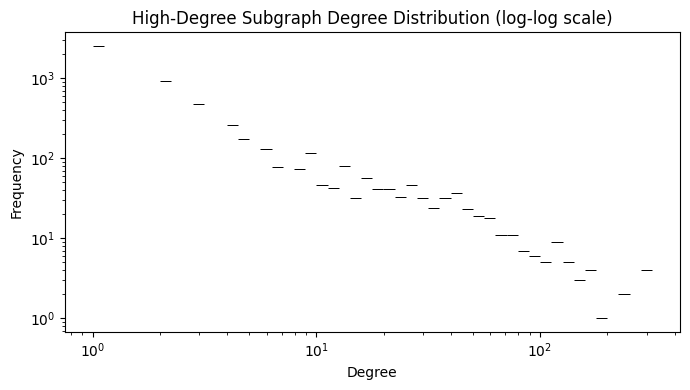

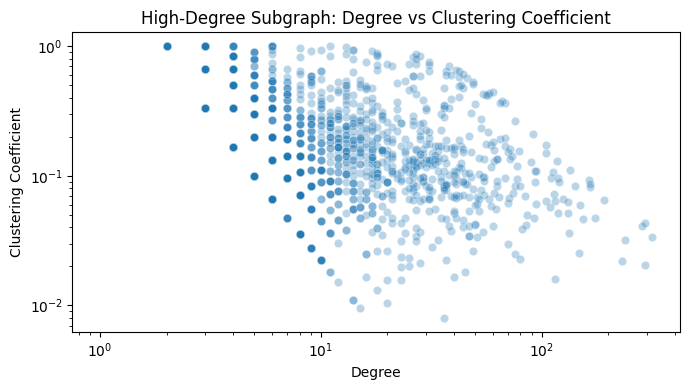


===== Low-Degree Subgraph =====
Nodes: 10000, Edges: 93, Density: 0.000002
Average Clustering Coefficient: 0.000000
Degree Statistics: {'Mean Degree': 0.0186, 'Std Degree': 0.13510751274448063, 'Min Degree': 0, 'Max Degree': 1}
Average Shortest Path Length (largest CC): 1.000000
Connected Components: 9907
Spearman correlation (degree vs clustering): SignificanceResult(statistic=nan, pvalue=nan)
Pearson correlation (degree vs clustering): PearsonRResult(statistic=nan, pvalue=nan)


/var/folders/q1/77qh9r_j70z1rkw5l3wb6l940000gn/T/ipykernel_17398/1729963314.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(df_corr['degree'], df_corr['clustering'])
/var/folders/q1/77qh9r_j70z1rkw5l3wb6l940000gn/T/ipykernel_17398/1729963314.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(df_corr['degree'], df_corr['clustering'])


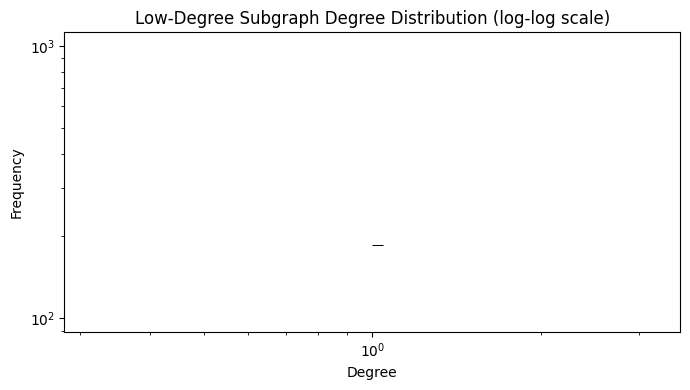

/var/folders/q1/77qh9r_j70z1rkw5l3wb6l940000gn/T/ipykernel_17398/1729963314.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


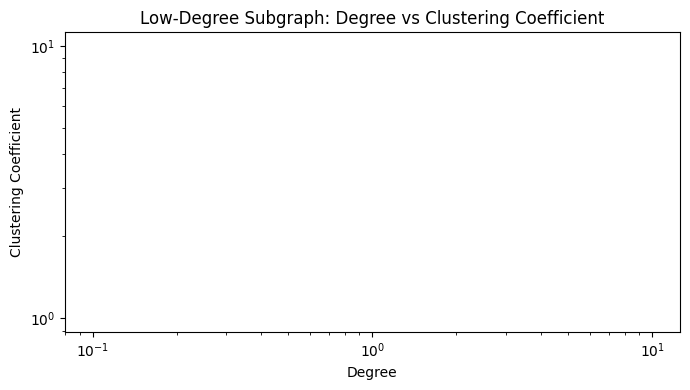

In [ ]:
# Build subgraphs
G_high = G_signed.subgraph(high_nodes).copy()
G_low = G_signed.subgraph(low_nodes).copy()

def analyze_graph_stats(G, name="Graph"):
    print(f"{name}")
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    print(f'Nodes: {num_nodes}, Edges: {num_edges}, Density: {density:.6f}')
    
    G_undirected = G.to_undirected()
    avg_clustering = nx.average_clustering(G_undirected)
    print(f'Average Clustering Coefficient: {avg_clustering:.6f}')
    
    degrees = [deg for _, deg in G.degree()]
    degree_stats = {
        "Mean Degree": np.mean(degrees),
        "Std Degree": np.std(degrees),
        "Min Degree": np.min(degrees),
        "Max Degree": np.max(degrees),
    }
    print("Degree Statistics:", degree_stats)
    
    if nx.is_connected(G_undirected):
        avg_path_len = nx.average_shortest_path_length(G_undirected)
    else:
        largest_cc = max(nx.connected_components(G_undirected), key=len)
        G_cc = G_undirected.subgraph(largest_cc)
        avg_path_len = nx.average_shortest_path_length(G_cc)
    print(f'Average Shortest Path Length (largest CC): {avg_path_len:.6f}')
    
    num_conn_comp = nx.number_connected_components(G_undirected)
    print(f'Connected Components: {num_conn_comp}')
    
    clustering_dict = nx.clustering(G_undirected)
    clustering_values = [clustering_dict[n] for n in G.nodes()]
    degree_values = [G.degree(n) for n in G.nodes()]
    df_corr = pd.DataFrame({'degree': degree_values, 'clustering': clustering_values})
    
    spearman_corr = spearmanr(df_corr['degree'], df_corr['clustering'])
    pearson_corr = pearsonr(df_corr['degree'], df_corr['clustering'])
    print(f"Spearman correlation (degree vs clustering): {spearman_corr}")
    print(f"Pearson correlation (degree vs clustering): {pearson_corr}")
    
    # Plot degree distribution
    plt.figure(figsize=(7, 4))
    sns.histplot(degree_values, bins=50, log_scale=(True, True))
    plt.title(f'{name} Degree Distribution (log-log scale)')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Clustering vs Degree scatter
    plt.figure(figsize=(7, 4))
    sns.scatterplot(x='degree', y='clustering', data=df_corr, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{name}: Degree vs Clustering Coefficient')
    plt.xlabel('Degree')
    plt.ylabel('Clustering Coefficient')
    plt.tight_layout()
    plt.show()

# Analyze both subgraphs
analyze_graph_stats(G_high, name="High-Degree Subgraph")
analyze_graph_stats(G_low, name="Low-Degree Subgraph")


# Baseline

## Low degree nodes 

In [29]:
def epinions_low_degree_ego_baseline():

    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1
    full_graph = dgl.graph((edges["src"], edges["dst"]), num_nodes=num_nodes)
    degrees = full_graph.in_degrees().numpy()
    node_ids = np.arange(num_nodes)

    # Load fixed low-degree node IDs
    with open("signed_low_degree_nodes.txt", "r") as f:
        low_nodes = [int(line.strip()) for line in f]

    ego_nodes = set(low_nodes)



    for u, v in zip(edges["src"], edges["dst"]):
        if u in ego_nodes:
            ego_nodes.add(v)
        if v in ego_nodes:
            ego_nodes.add(u)

    ego_nodes = list(ego_nodes)
    mask = np.isin(edges["src"], ego_nodes) & np.isin(edges["dst"], ego_nodes)
    sub_edges = edges[mask].copy()
    selected_nodes = np.unique(np.concatenate([sub_edges["src"].values, sub_edges["dst"].values]))
    node_map = {old: new for new, old in enumerate(selected_nodes)}

    sub_src = np.array([node_map[s] for s in sub_edges["src"]])
    sub_dst = np.array([node_map[d] for d in sub_edges["dst"]])
    sub_signs = sub_edges["sign"].values

    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(selected_nodes))
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    # Signed degree features
    pos_deg = torch.zeros(sub_graph.num_nodes())
    neg_deg = torch.zeros(sub_graph.num_nodes())
    for s, d, sign in zip(sub_src, sub_dst, sub_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_negative_edges(graph, n_samples):
        neg_edges = []
        while len(neg_edges) < n_samples:
            u = torch.randint(0, graph.num_nodes(), (n_samples,))
            v = torch.randint(0, graph.num_nodes(), (n_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:n_samples], dtype=torch.long)

    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    if len(pos_edges) == 0:
        return None
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE Model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)
        def forward(self, g, x):
            h = F.relu(self.conv1(g, x))
            return self.conv2(g, h)

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(sub_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_preds = model(sub_graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    degs = sub_graph.in_degrees().numpy()
    edge_deg = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = test_preds[idx]

        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }
# 10 runs
results = [epinions_low_degree_ego_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.934631  0.865781   0.854397  0.889647  0.869635    0.124897  0.614582   
std   0.008168  0.024840   0.055852  0.033363  0.017153    0.012377  0.071074   

        EO Gap  
mean  0.200039  
std   0.060130  

95% Confidence Intervals:
AUC: 0.9346 ± 0.0058
Accuracy: 0.8658 ± 0.0178
Precision: 0.8544 ± 0.0400
Recall: 0.8896 ± 0.0239
F1: 0.8696 ± 0.0123
Degree Gap: 0.1249 ± 0.0089
DP Gap: 0.6146 ± 0.0508
EO Gap: 0.2000 ± 0.0430


## High degree nodes 

In [30]:
def epinions_high_degree_ego_baseline():
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1
    full_graph = dgl.graph((edges["src"], edges["dst"]), num_nodes=num_nodes)
    degrees = full_graph.in_degrees().numpy()
    node_ids = np.arange(num_nodes)


    # Load fixed high-degree 
    with open("signed_high_degree_nodes.txt", "r") as f:
        high_nodes = [int(line.strip()) for line in f]

    ego_nodes = set(high_nodes)


    # ego nodes 
    for u, v in zip(edges["src"], edges["dst"]):
        if u in ego_nodes:
            ego_nodes.add(v)
        if v in ego_nodes:
            ego_nodes.add(u)

    ego_nodes = list(ego_nodes)
    mask = np.isin(edges["src"], ego_nodes) & np.isin(edges["dst"], ego_nodes)
    sub_edges = edges[mask].copy()
    selected_nodes = np.unique(np.concatenate([sub_edges["src"].values, sub_edges["dst"].values]))
    node_map = {old: new for new, old in enumerate(selected_nodes)}

    sub_src = np.array([node_map[s] for s in sub_edges["src"]])
    sub_dst = np.array([node_map[d] for d in sub_edges["dst"]])
    sub_signs = sub_edges["sign"].values

    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(selected_nodes))
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    # Signed degree features
    pos_deg = torch.zeros(sub_graph.num_nodes())
    neg_deg = torch.zeros(sub_graph.num_nodes())
    for s, d, sign in zip(sub_src, sub_dst, sub_signs):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_negative_edges(graph, n_samples):
        neg_edges = []
        while len(neg_edges) < n_samples:
            u = torch.randint(0, graph.num_nodes(), (n_samples,))
            v = torch.randint(0, graph.num_nodes(), (n_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:n_samples], dtype=torch.long)

    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    if len(pos_edges) == 0:
        return None
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE Model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)
        def forward(self, g, x):
            h = F.relu(self.conv1(g, x))
            return self.conv2(g, h)

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(sub_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_preds = model(sub_graph, features, test_edges).numpy()
    pred_labels = (test_preds > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    degs = sub_graph.in_degrees().numpy()
    edge_deg = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = test_preds[idx]

        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }

# 10 runs
results = [epinions_high_degree_ego_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.931537  0.856333   0.853168  0.877357  0.860175    0.125788  0.618064   
std   0.013937  0.032897   0.075667  0.063357  0.021572    0.035484  0.111331   

        EO Gap  
mean  0.222178  
std   0.114724  

95% Confidence Intervals:
AUC: 0.9315 ± 0.0100
Accuracy: 0.8563 ± 0.0235
Precision: 0.8532 ± 0.0541
Recall: 0.8774 ± 0.0453
F1: 0.8602 ± 0.0154
Degree Gap: 0.1258 ± 0.0254
DP Gap: 0.6181 ± 0.0796
EO Gap: 0.2222 ± 0.0821


# Fairdrop

## Low degree nodes

In [31]:
def epinions_low_degree_ego_fairdrop(drop_prob=0.5, debug=False):
    # Load edges
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    total_nodes = max(edges["src"].max(), edges["dst"].max()) + 1
    degrees = dgl.graph((edges["src"], edges["dst"]), num_nodes=total_nodes).in_degrees().numpy()

        # Load fixed low-degree node IDs
    with open("signed_low_degree_nodes.txt", "r") as f:
        low_nodes = [int(line.strip()) for line in f]

    ego_nodes = set(low_nodes)


    # Include 1-hop neighbors
    for u, v in zip(edges["src"], edges["dst"]):
        if u in ego_nodes:
            ego_nodes.add(v)
        if v in ego_nodes:
            ego_nodes.add(u)

    ego_nodes = list(ego_nodes)
    mask = np.isin(edges["src"], ego_nodes) & np.isin(edges["dst"], ego_nodes)
    sub_edges = edges[mask].copy()

    selected_nodes = np.unique(np.concatenate([sub_edges["src"].values, sub_edges["dst"].values]))
    node_map = {old: new for new, old in enumerate(selected_nodes)}
    final_edges = sub_edges.copy()
    sub_src = np.array([node_map[s] for s in final_edges["src"]])
    sub_dst = np.array([node_map[d] for d in final_edges["dst"]])
    sub_signs = final_edges["sign"].values
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(selected_nodes))
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    degrees_sub = sub_graph.in_degrees().numpy()
    mean_deg = degrees_sub.mean()
    sensitive_attr = np.where(degrees_sub <= mean_deg, 0, 1)

    def apply_fairdrop(graph, sensitive_attr, drop_prob):
        src, dst = graph.edges()
        mask = []
        for u, v in zip(src.tolist(), dst.tolist()):
            if sensitive_attr[u] == sensitive_attr[v]:
                keep = np.random.rand() > drop_prob
            else:
                keep = True
            mask.append(keep)
        mask = torch.tensor(mask)
        new_src = src[mask]
        new_dst = dst[mask]
        fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())
        if "sign" in graph.edata:
            fair_graph.edata["sign"] = graph.edata["sign"][mask]
        return fair_graph

    fair_graph = apply_fairdrop(sub_graph, sensitive_attr, drop_prob)
    if fair_graph.num_edges() == 0:
        return None

    fair_graph = dgl.add_self_loop(fair_graph)

    if debug:
        print(f"Original edges: {sub_graph.num_edges()}, After FairDrop: {fair_graph.num_edges()}")

    # Features
    pos_deg = torch.zeros(fair_graph.num_nodes())
    neg_deg = torch.zeros(fair_graph.num_nodes())
    for s, d, sign in zip(*fair_graph.edges(), fair_graph.edata["sign"]):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_neg(graph, n):
        neg_edges = []
        while len(neg_edges) < n:
            u = torch.randint(0, graph.num_nodes(), (n,))
            v = torch.randint(0, graph.num_nodes(), (n,))
            mask = ~graph.has_edges_between(u, v)
            pairs = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(pairs.tolist())
        return torch.tensor(neg_edges[:n])

    src, dst = fair_graph.edges()
    pos_edges = torch.stack((src, dst), dim=1)
    if len(pos_edges) == 0: return None
    neg_edges = sample_neg(fair_graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE Model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden, out, allow_zero_in_degree=True)
        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden, out)
            self.decoder = MLPDecoder(out)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()
    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(fair_graph, features, train_edges), train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_score = model(fair_graph, features, test_edges).numpy()
    y_pred = (y_score > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), y_score)
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    degs = fair_graph.in_degrees().numpy()
    edge_degrees = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    thresh = np.mean(edge_degrees)
    bin_idx = np.array([0 if d <= thresh else 1 for d in edge_degrees])

    degree_scores, proportions, recalls = [], [], []
    for i in [0, 1]:
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0: continue
        y_t, y_p, y_s = test_labels[idx], y_pred[idx], y_score[idx]
        if len(np.unique(y_t)) > 1:
            degree_scores.append(roc_auc_score(y_t, y_s))
        proportions.append(np.mean(y_p))
        cm = confusion_matrix(y_t, y_p)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else np.nan,
        "DP Gap": max(proportions) - min(proportions) if len(proportions) >= 2 else np.nan,
        "EO Gap": max(recalls) - min(recalls) if len(recalls) >= 2 else np.nan
    }

# 10 runs
results = [epinions_low_degree_ego_fairdrop() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.855190  0.785885   0.816305  0.744974  0.776894    0.009626  0.657855   
std   0.010553  0.016860   0.048867  0.038050  0.008608    0.007418  0.061771   

        EO Gap  
mean  0.394071  
std   0.057360  

95% Confidence Intervals:
AUC: 0.8552 ± 0.0075
Accuracy: 0.7859 ± 0.0121
Precision: 0.8163 ± 0.0350
Recall: 0.7450 ± 0.0272
F1: 0.7769 ± 0.0062
Degree Gap: 0.0096 ± 0.0053
DP Gap: 0.6579 ± 0.0442
EO Gap: 0.3941 ± 0.0410


## High degree nodes 

In [32]:
def epinions_high_degree_ego_fairdrop(drop_prob=0.5, debug=False):

    # Load Epinions data
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    total_nodes = max(edges["src"].max(), edges["dst"].max()) + 1
    full_graph = dgl.graph((edges["src"], edges["dst"]), num_nodes=total_nodes)
    degrees = full_graph.in_degrees().numpy()

    # Load fixed high-degree
    with open("signed_high_degree_nodes.txt", "r") as f:
        high_nodes = [int(line.strip()) for line in f]

    ego_nodes = set(high_nodes)

    # Include 1-hop neighbors
    for u, v in zip(edges["src"], edges["dst"]):
        if u in ego_nodes:
            ego_nodes.add(v)
        if v in ego_nodes:
            ego_nodes.add(u)

    ego_nodes = list(ego_nodes)
    mask = np.isin(edges["src"], ego_nodes) & np.isin(edges["dst"], ego_nodes)
    sub_edges = edges[mask].copy()

    selected_nodes = np.unique(np.concatenate([sub_edges["src"].values, sub_edges["dst"].values]))
    node_map = {old: new for new, old in enumerate(selected_nodes)}
    final_edges = sub_edges.copy()

    sub_src = np.array([node_map[s] for s in final_edges["src"]])
    sub_dst = np.array([node_map[d] for d in final_edges["dst"]])
    sub_signs = final_edges["sign"].values

    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(selected_nodes))
    sub_graph.edata["sign"] = torch.tensor(sub_signs, dtype=torch.float32)

    degrees_sub = sub_graph.in_degrees().numpy()
    mean_deg = degrees_sub.mean()
    sensitive_attr = np.where(degrees_sub <= mean_deg, 0, 1)

    def apply_fairdrop(graph, sensitive_attr, drop_prob):
        src, dst = graph.edges()
        mask = [(np.random.rand() > drop_prob if sensitive_attr[u] == sensitive_attr[v] else True)
                for u, v in zip(src.tolist(), dst.tolist())]
        mask = torch.tensor(mask)
        new_src = src[mask]
        new_dst = dst[mask]
        fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())
        fair_graph.edata["sign"] = graph.edata["sign"][mask]
        return fair_graph

    fair_graph = apply_fairdrop(sub_graph, sensitive_attr, drop_prob)
    if fair_graph.num_edges() == 0: return None
    fair_graph = dgl.add_self_loop(fair_graph)

    if debug:
        print(f"Original edges: {sub_graph.num_edges()}, After FairDrop: {fair_graph.num_edges()}")

    # Features
    pos_deg = torch.zeros(fair_graph.num_nodes())
    neg_deg = torch.zeros(fair_graph.num_nodes())
    for s, d, sign in zip(*fair_graph.edges(), fair_graph.edata["sign"]):
        if sign > 0:
            pos_deg[s] += 1
            pos_deg[d] += 1
        else:
            neg_deg[s] += 1
            neg_deg[d] += 1
    features = torch.stack([pos_deg, neg_deg], dim=1)

    def sample_neg(graph, n):
        neg_edges = []
        while len(neg_edges) < n:
            u = torch.randint(0, graph.num_nodes(), (n,))
            v = torch.randint(0, graph.num_nodes(), (n,))
            mask = ~graph.has_edges_between(u, v)
            pairs = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(pairs.tolist())
        return torch.tensor(neg_edges[:n])

    src, dst = fair_graph.edges()
    pos_edges = torch.stack((src, dst), dim=1)
    if len(pos_edges) == 0: return None
    neg_edges = sample_neg(fair_graph, len(pos_edges))

    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # GAE Model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.conv1 = dglnn.GraphConv(in_feats, hidden, allow_zero_in_degree=True)
            self.conv2 = dglnn.GraphConv(hidden, out, allow_zero_in_degree=True)
        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edges):
            src, dst = edges[:, 0], edges[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden, out):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden, out)
            self.decoder = MLPDecoder(out)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    model = GAE(2, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()
    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(fair_graph, features, train_edges), train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_score = model(fair_graph, features, test_edges).numpy()
    y_pred = (y_score > 0.5).astype(int)

    auc = roc_auc_score(test_labels.numpy(), y_score)
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    degs = fair_graph.in_degrees().numpy()
    edge_degrees = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    thresh = np.mean(edge_degrees)
    bin_idx = np.array([0 if d <= thresh else 1 for d in edge_degrees])

    degree_scores, proportions, recalls = [], [], []
    for i in [0, 1]:
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0: continue
        y_t, y_p, y_s = test_labels[idx], y_pred[idx], y_score[idx]
        if len(np.unique(y_t)) > 1:
            degree_scores.append(roc_auc_score(y_t, y_s))
        proportions.append(np.mean(y_p))
        cm = confusion_matrix(y_t, y_p)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else np.nan,
        "DP Gap": max(proportions) - min(proportions) if len(proportions) >= 2 else np.nan,
        "EO Gap": max(recalls) - min(recalls) if len(recalls) >= 2 else np.nan
    }

# 10 runs
results = [epinions_high_degree_ego_fairdrop() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.856694  0.786238   0.832123  0.725009  0.772056    0.011199  0.679947   
std   0.009118  0.010044   0.051846  0.047441  0.007022    0.009929  0.064908   

        EO Gap  
mean  0.421900  
std   0.069859  

95% Confidence Intervals:
AUC: 0.8567 ± 0.0065
Accuracy: 0.7862 ± 0.0072
Precision: 0.8321 ± 0.0371
Recall: 0.7250 ± 0.0339
F1: 0.7721 ± 0.0050
Degree Gap: 0.0112 ± 0.0071
DP Gap: 0.6799 ± 0.0464
EO Gap: 0.4219 ± 0.0500


# FairWalk

## Low degree nodes

In [34]:
def epinions_low_degree_ego_fairwalk(sample_size=10000, walk_length=20, num_walks=3, C=1.0):
    # Load data
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})
    num_nodes = max(edges["src"].max(), edges["dst"].max()) + 1

    # Build undirected graph
    graph_full = nx.from_edgelist(zip(edges["src"], edges["dst"]))
    degrees = dict(graph_full.degree())

    # Load fixed low-degree node IDs
    with open("signed_low_degree_nodes.txt", "r") as f:
        low_nodes = [int(line.strip()) for line in f]

    # Build 1-hop ego network
    ego_nodes = set(low_nodes)
    for node in low_nodes:
        ego_nodes.update(graph_full.neighbors(node))
    ego_subgraph = graph_full.subgraph(ego_nodes).copy()

    # Sensitive attribute (based on subgraph degrees)
    degrees_sub = dict(ego_subgraph.degree())
    mean_deg = np.mean(list(degrees_sub.values()))
    sensitive_attr = {n: 0 if degrees_sub[n] <= mean_deg else 1 for n in ego_subgraph.nodes()}

    # Sample positive and negative edges
    all_edges = list(ego_subgraph.edges())
    pos_edges = random.sample(all_edges, min(sample_size, len(all_edges)))
    nodes = list(ego_subgraph.nodes())
    neg_edges = set()
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if u != v and not ego_subgraph.has_edge(u, v):
            neg_edges.add((u, v))
    neg_edges = list(neg_edges)

    # Prepare datasets
    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2, stratify=labels)

    # Restrict walks to training nodes only
    train_nodes = set(u for u, v in train_pairs) | set(v for u, v in train_pairs)
    train_subgraph = ego_subgraph.subgraph(train_nodes).copy()
    train_attr = {n: sensitive_attr[n] for n in train_subgraph.nodes()}

    # FairWalk generation
    def generate_fairwalks(graph, attr_dict, num_walks, walk_length):
        walks = []
        for _ in range(num_walks):
            nodes = list(graph.nodes())
            random.shuffle(nodes)
            for start in nodes:
                walk = [start]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    walk.append(random.choice(opp_group if opp_group else neighbors))
                walks.append([str(n) for n in walk])
        return walks

    walks = generate_fairwalks(train_subgraph, train_attr, num_walks, walk_length)
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    # Feature extraction
    def make_features(pairs, labels):
        X, y, kept = [], [], []
        for (u, v), label in zip(pairs, labels):
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return np.array(X), np.array(y), kept

    X_train, y_train, _ = make_features(train_pairs, y_train)
    X_test, y_test, test_edges = make_features(test_pairs, y_test)

    if len(np.unique(y_test)) < 2:
        return {k: np.nan for k in ["AUC", "Accuracy", "Precision", "Recall", "F1", "Degree Gap", "DP Gap", "EO Gap"]}

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    # Evaluation metrics
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Fairness metrics
    edge_groups = np.array([max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges])
    high_mask = edge_groups == 1
    low_mask = edge_groups == 0

    if high_mask.sum() > 0 and low_mask.sum() > 0:
        degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
        dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())
        tpr_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask) / (np.sum((y_test == 1) & high_mask) + 1e-8)
        tpr_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask) / (np.sum((y_test == 1) & low_mask) + 1e-8)
        eo_gap = abs(tpr_high - tpr_low)
    else:
        degree_gap = dp_gap = eo_gap = np.nan

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# 10 runs
results = [epinions_low_degree_ego_fairwalk(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.845398  0.749259   0.903423  0.735285  0.810683    0.328337  0.459958   
std   0.008598  0.006586   0.007722  0.008306  0.005210    0.017963  0.030362   

        EO Gap  
mean  0.182266  
std   0.132294  

95% Confidence Intervals:
AUC: 0.8454 ± 0.0062
Accuracy: 0.7493 ± 0.0047
Precision: 0.9034 ± 0.0055
Recall: 0.7353 ± 0.0059
F1: 0.8107 ± 0.0037
Degree Gap: 0.3283 ± 0.0128
DP Gap: 0.4600 ± 0.0217
EO Gap: 0.1823 ± 0.0946


## High degree nodes 

In [35]:
def epinions_high_degree_ego_fairwalk(sample_size=10000, walk_length=20, num_walks=3, C=1.0):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    edges = pd.DataFrame({"src": mtx.row, "dst": mtx.col, "sign": mtx.data})

    graph_full = nx.from_edgelist(zip(edges["src"], edges["dst"]))
    degrees = dict(graph_full.degree())

    # Load fixed high-degree nodes
    with open("signed_high_degree_nodes.txt", "r") as f:
        high_nodes = [int(line.strip()) for line in f]

    # Build 1-hop ego network
    ego_nodes = set(high_nodes)
    for node in high_nodes:
        ego_nodes.update(graph_full.neighbors(node))
    subgraph = graph_full.subgraph(ego_nodes).copy()

    # Sensitive attribute based on subgraph degrees
    sub_degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(sub_degrees.values()))
    sensitive_attr = {n: 0 if sub_degrees[n] <= mean_deg else 1 for n in subgraph.nodes()}

    # Sample positive edges
    all_edges = list(subgraph.edges())
    pos_edges = random.sample(all_edges, min(sample_size, len(all_edges)))

    # Sample negative edges
    nodes = list(subgraph.nodes())
    neg_edges = set()
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if u != v and not subgraph.has_edge(u, v):
            neg_edges.add((u, v))
    neg_edges = list(neg_edges)

    # Prepare dataset
    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2, stratify=labels)

    # Subgraph for training walks (no test leakage)
    train_nodes = set(u for u, v in train_pairs) | set(v for u, v in train_pairs)
    train_subgraph = subgraph.subgraph(train_nodes).copy()
    train_attr = {n: sensitive_attr[n] for n in train_subgraph.nodes()}

    # FairWalk
    def generate_fairwalks(graph, attr_dict, num_walks, walk_length):
        walks = []
        for _ in range(num_walks):
            nodes = list(graph.nodes())
            random.shuffle(nodes)
            for start in nodes:
                walk = [start]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    walk.append(random.choice(opp_group if opp_group else neighbors))
                walks.append([str(n) for n in walk])
        return walks

    walks = generate_fairwalks(train_subgraph, train_attr, num_walks, walk_length)
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    # Build features
    def make_features(pairs, labels):
        X, y, kept = [], [], []
        for (u, v), label in zip(pairs, labels):
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return np.array(X), np.array(y), kept

    X_train, y_train, _ = make_features(train_pairs, y_train)
    X_test, y_test, test_edges = make_features(test_pairs, y_test)

    if len(np.unique(y_test)) < 2:
        return {k: np.nan for k in ["AUC", "Accuracy", "Precision", "Recall", "F1", "Degree Gap", "DP Gap", "EO Gap"]}

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    # Standard metrics
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Fairness metrics
    edge_groups = np.array([max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges])
    high_mask = edge_groups == 1
    low_mask = edge_groups == 0

    if high_mask.sum() > 0 and low_mask.sum() > 0:
        degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
        dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())
        tpr_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask) / (np.sum((y_test == 1) & high_mask) + 1e-8)
        tpr_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask) / (np.sum((y_test == 1) & low_mask) + 1e-8)
        eo_gap = abs(tpr_high - tpr_low)
    else:
        degree_gap = dp_gap = eo_gap = np.nan

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run 10 times
results = [epinions_high_degree_ego_fairwalk(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.831813  0.737707   0.919049  0.724717  0.810337    0.302968  0.436271   
std   0.009406  0.005119   0.008274  0.008297  0.004366    0.019148  0.030328   

        EO Gap  
mean  0.175703  
std   0.123878  

95% Confidence Intervals:
AUC: 0.8318 ± 0.0067
Accuracy: 0.7377 ± 0.0037
Precision: 0.9190 ± 0.0059
Recall: 0.7247 ± 0.0059
F1: 0.8103 ± 0.0031
Degree Gap: 0.3030 ± 0.0137
DP Gap: 0.4363 ± 0.0217
EO Gap: 0.1757 ± 0.0886


# FairAdj 

## Low degree nodes

In [36]:
def epinions_low_degree_ego_fairadj(drop_rate=0.01, sample_size=10000, base_nodes=10000, C=1.0):
    # Load full graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    G_full = nx.from_edgelist(zip(mtx.row, mtx.col))

    # Load fixed low-degree nodes
    with open("signed_low_degree_nodes.txt", "r") as f:
        low_nodes = [int(line.strip()) for line in f]

    # 1-hop ego network expansion
    ego_nodes = set(low_nodes)
    for node in low_nodes:
        ego_nodes.update(G_full.neighbors(node))

    G = G_full.subgraph(ego_nodes).copy()

    # Sensitive attribute based on degree in the subgraph
    degrees = np.array([G.degree(n) for n in G.nodes()])
    mean_deg = degrees.mean()
    sensitive_attr = {node: int(G.degree(node) > mean_deg) for node in G.nodes()}

    # FairAdj filtering
    edges = list(G.edges())
    fair_edges = []
    for u, v in edges:
        same_group = sensitive_attr[u] == sensitive_attr[v]
        if not same_group or random.random() > drop_rate:
            fair_edges.append((u, v))
    fair_nx_graph = nx.from_edgelist(fair_edges)

    # Safe edge sampling
    available_pos_edges = list(fair_nx_graph.edges())
    if len(available_pos_edges) < sample_size:
        print(f"{len(available_pos_edges)} positive edges available, adjusting sample size.")
        sample_size = len(available_pos_edges)

    edges_pos = random.sample(available_pos_edges, sample_size)
    edges_neg = []
    while len(edges_neg) < sample_size:
        u, v = random.sample(list(fair_nx_graph.nodes()), 2)
        if not fair_nx_graph.has_edge(u, v):
            edges_neg.append((u, v))

    labels_pos = [1] * sample_size
    labels_neg = [0] * sample_size

    # Combine and split
    all_edges = edges_pos + edges_neg
    all_labels = labels_pos + labels_neg
    X_edges, y = shuffle(all_edges, all_labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(
        X_edges, y, test_size=0.2, stratify=y
    )

    # Node2Vec on subgraph of training nodes
    train_nodes = list(set([n for edge in train_edges for n in edge]))
    subgraph = fair_nx_graph.subgraph(train_nodes).copy()
    node2vec = Node2Vec(
        subgraph,
        dimensions=32,
        walk_length=20,
        num_walks=3,
        workers=4,
        quiet=True
    )
    w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=5)
    embeddings = {str(n): w2v_model.wv[str(n)] for n in subgraph.nodes()}

    # Create features
    def embed_edges(edge_list, labels):
        X, y, keep = [], [], []
        for (u, v), label in zip(edge_list, labels):
            if str(u) in embeddings and str(v) in embeddings:
                X.append(np.concatenate([embeddings[str(u)], embeddings[str(v)]]))
                y.append(label)
                keep.append((u, v))
        return np.array(X), np.array(y), keep

    X_train, y_train, train_edges = embed_edges(train_edges, train_labels)
    X_test, y_test, test_edges = embed_edges(test_edges, test_labels)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)

    # Performance metrics
    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Fairness metrics
    edge_deg = [max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    if high_mask.sum() > 0 and low_mask.sum() > 0:
        p_high = np.mean(y_scores[high_mask])
        p_low = np.mean(y_scores[low_mask])
        degree_gap = abs(p_high - p_low)

        dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask]))

        tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
        pos_high = np.sum((y_test == 1) & high_mask)
        tpr_high = tp_high / (pos_high + 1e-8)

        tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
        pos_low = np.sum((y_test == 1) & low_mask)
        tpr_low = tp_low / (pos_low + 1e-8)

        eo_gap = abs(tpr_high - tpr_low)
    else:
        degree_gap = dp_gap = eo_gap = np.nan

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }


# Run 10 times
results = [epinions_low_degree_ego_fairadj(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.907841  0.879079   0.900523  0.937028  0.918386    0.628415  0.792068   
std   0.010611  0.008053   0.006295  0.008762  0.005514    0.014163  0.015493   

        EO Gap  
mean  0.785536  
std   0.072591  

95% Confidence Intervals:
AUC: 0.9078 ± 0.0076
Accuracy: 0.8791 ± 0.0058
Precision: 0.9005 ± 0.0045
Recall: 0.9370 ± 0.0063
F1: 0.9184 ± 0.0039
Degree Gap: 0.6284 ± 0.0101
DP Gap: 0.7921 ± 0.0111
EO Gap: 0.7855 ± 0.0519


## High degree nodes 


In [37]:
def epinions_high_degree_ego_fairadj(drop_rate=0.01, sample_size=10000, num_nodes=10000, C=1.0):
    # Load graph
    mtx = scipy.io.mmread("soc-sign-epinions.mtx").tocoo()
    G_full = nx.from_edgelist(zip(mtx.row, mtx.col))

    # Load fixed high-degree node IDs
    with open("signed_high_degree_nodes.txt", "r") as f:
        high_nodes = set(int(line.strip()) for line in f)
    ego_nodes = set(high_nodes)

    # Expand to 1-hop ego network
    for node in list(high_nodes):
        ego_nodes.update(G_full.neighbors(node))

    # Induce subgraph
    G = G_full.subgraph(ego_nodes).copy()

    # Sensitive attribute: degree above/below mean in ego subgraph
    degrees = np.array([G.degree(n) for n in G.nodes()])
    mean_deg = degrees.mean()
    sensitive_attr = {n: int(G.degree(n) > mean_deg) for n in G.nodes()}

    # FairAdj: drop edges between same-group nodes with some probability
    fair_edges = []
    for u, v in G.edges():
        same_group = sensitive_attr[u] == sensitive_attr[v]
        if not same_group or random.random() > drop_rate:
            fair_edges.append((u, v))
    fair_nx_graph = nx.from_edgelist(fair_edges)

    # Sample positive and negative edges
    available_pos_edges = list(fair_nx_graph.edges())
    sample_size = min(sample_size, len(available_pos_edges))
    edges_pos = random.sample(available_pos_edges, sample_size)

    edges_neg = []
    nodes = list(fair_nx_graph.nodes())
    while len(edges_neg) < sample_size:
        u, v = random.sample(nodes, 2)
        if not fair_nx_graph.has_edge(u, v) and u != v:
            edges_neg.append((u, v))

    # Labels
    labels_pos = [1] * sample_size
    labels_neg = [0] * sample_size

    # Combine and split
    all_edges = edges_pos + edges_neg
    all_labels = labels_pos + labels_neg
    X_edges, y = shuffle(all_edges, all_labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(
        X_edges, y, test_size=0.2
    )

    # Train subgraph for Node2Vec
    train_nodes = list(set(n for edge in train_edges for n in edge))
    subgraph = fair_nx_graph.subgraph(train_nodes).copy()
    node2vec = Node2Vec(
        subgraph,
        dimensions=32,
        walk_length=20,
        num_walks=3,
        workers=4,
        quiet=True
    )
    w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=5)
    embeddings = {str(n): w2v_model.wv[str(n)] for n in subgraph.nodes()}

    # Embed edges
    def embed_edges(edge_list, labels):
        X, y, kept = [], [], []
        for (u, v), label in zip(edge_list, labels):
            if str(u) in embeddings and str(v) in embeddings:
                X.append(np.concatenate([embeddings[str(u)], embeddings[str(v)]]))
                y.append(label)
                kept.append((u, v))
        return np.array(X), np.array(y), kept

    X_train, y_train, train_edges = embed_edges(train_edges, train_labels)
    X_test, y_test, test_edges = embed_edges(test_edges, test_labels)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)

    # Evaluation
    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Fairness metrics
    edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    p_high = np.mean(y_scores[high_mask]) if high_mask.sum() > 0 else 0.0
    p_low = np.mean(y_scores[low_mask]) if low_mask.sum() > 0 else 0.0
    degree_gap = abs(p_high - p_low)

    dp_gap = abs(np.mean(y_pred[high_mask]) - np.mean(y_pred[low_mask])) if high_mask.sum() > 0 and low_mask.sum() > 0 else np.nan

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8) if pos_high > 0 else 0.0

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8) if pos_low > 0 else 0.0

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }


# 10 runs
results = [epinions_high_degree_ego_fairadj(C=1.0) for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(['mean', 'std']))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=st.sem(df[col]))
    print(f"{col}: {mean:.4f} ± {(ci_high - mean):.4f}")


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision   Recall        F1  Degree Gap    DP Gap  \
mean  0.891455   0.87115   0.911702  0.92294  0.917250    0.598342  0.785530   
std   0.006745   0.00682   0.007436  0.00775  0.004544    0.018350  0.027461   

        EO Gap  
mean  0.830052  
std   0.115079  

95% Confidence Intervals:
AUC: 0.8915 ± 0.0048
Accuracy: 0.8711 ± 0.0049
Precision: 0.9117 ± 0.0053
Recall: 0.9229 ± 0.0055
F1: 0.9173 ± 0.0033
Degree Gap: 0.5983 ± 0.0131
DP Gap: 0.7855 ± 0.0196
EO Gap: 0.8301 ± 0.0823
